# Прорыв волатильности на 15 инструментах

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
import seaborn as sns
import yfinance as yf

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
#plt.rcParams['figure.constrained_layout.use'] = True

## Загрузка данных

In [2]:
start = '2012-05-01'
end = '2021-01-28'
assets = [
    'SBER.ME',
    'GAZP.ME',
    'VTBR.ME',
    'LKOH.ME',
    'IMOEX.ME',
    'SPY',
    'AAPL',
    'TSLA',
    'XOM', 
    'BAC', 
    'ZW=F',
    'ZS=F',
    'CL=F',
    'RUB=X',
    'EUR=X',
    #'BTC-USD',
    #'ETH-USD',
    #'XRP-USD',
    #'LTC-USD'
]
dfa = yf.download(assets, start=start, end=end)

[*********************100%***********************]  15 of 15 completed


In [4]:
# датафрейм для сделок
logs = pd.DataFrame(columns=[
    'Date_In',
    'Date_Out',
    'Direction',
    'Price_In',
    'Price_Out',
    'Comment'
])

In [5]:
# временные переменные для рассчётов
date_in = []
date_out = [] 
direction = []
price_in = 0 
price_out = 0 
price_stop = 0
comment = []

In [6]:
#для статистики
stat = pd.DataFrame(columns=[
    'Asset',
    'Direction',
    'Coef_Prev_Day',
    'Depo_Perc',
    'Start_Date',
    'End_Date',
    'Return_On_Account',
    'Avg_Year_Return',
    #'Month_Return',
    #'Gross_Profit',
    #'Gross_Loss',
    'Num_Of_Trades',
    'Num_Of_Win_Trades',
    'Num_Of_Loss_Trades',
    'Percent_Profitable',
    'Largest_Win_Trade',
    'Largest_Loss_trade',
    'Avg_Win_Trade',
    'Avg_Loss_Trade',
    'Avg_Win_Avg_Loss',
    'Avg_Trade',
    'Max_Cons_Win',
    'Max_Cons_Loss',
    'Max_Drawdown',
    'Profit_Factor',
    'Sharpe_Ratio'
])

## Разные функции

In [7]:
def prepare_data(df_,coef_prev_day,depo_percent):
    """Подготовка данных для рассчета.

    df: исходных ohlcv датафрейм
    coef: коэффициент для диапазона предыдущего дня (по умолчанию 1)
    coef_stop: коэффициен для стопа (по умолчанию 2)
    depo_percent: процент от депозита, который можно потерять

    """
    #df['Prev_Day_Volatility'] = (df['High']-df['Close']).shift(1) #так написано в книге, но так полный слив
    df_['Prev_Day_Volatility'] = (df_['High']-df_['Low']).shift(1)*coef_prev_day #а вот так хоть какие-то движения

    df_['Buy'] = np.where((df_['Open']+df_['Prev_Day_Volatility'])<df_['High'], df_['Open']+df_['Prev_Day_Volatility'], np.nan)
    #df_['Buy_Stop'] = np.where(df_['Buy']>0, df_['Buy']-df_['Prev_Day_Volatility']/coef_stop, np.nan) #стоп от точки входа
    df_['Buy_Stop'] = np.where(df_['Buy']>0, df_['Buy']-df_['Buy']*(depo_percent/100), np.nan)

    df_['Sell'] = np.where((df_['Open']-df_['Prev_Day_Volatility'])>df_['Low'], df_['Open']-df_['Prev_Day_Volatility'], np.nan)
    #df_['Sell_Stop'] = np.where(df_['Sell']>0, df_['Sell']+df_['Prev_Day_Volatility']/coef_stop, np.nan) #стоп от точки входа
    df_['Sell_Stop'] = np.where(df_['Sell']>0, df_['Sell']+df_['Sell']*(depo_percent/100), np.nan)

    return df_

In [8]:
def add_trade(logs, date_in, date_out, direction, price_in, price_out, comment):
    logs.loc[len(logs)] = [
        date_in,
        date_out,
        direction,
        price_in,
        price_out,
        comment
    ]
    return logs

In [9]:
def clear(date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Очистка временных переменных
    """
    return [], [], [], 0, 0, 0, []

In [10]:
def calc_buy(df, logs, date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Рассчет покупок
    """
    inside_deal = False
    n_days = 0 # дней в сделке
    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
    for row in df.itertuples():
        if inside_deal==False:
            if row.Buy>0:
                # вход в сделку
                inside_deal = True
                date_in = row.Index
                price_in = row.Buy
                direction = 'Buy'
                price_stop = row.Buy_Stop
        else:
            n_days+=1
            if row.Open > price_in:
                # техника катапультирования
                date_out = row.Index
                price_out = row.Open
                comment = 'bailout'
                logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                #clear
                inside_deal = False
                date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                n_days = 0

                if row.Buy>0:
                    # вход в сделку в день катапультирования
                    inside_deal = True
                    date_in = row.Index
                    price_in = row.Buy
                    direction = 'Buy'
                    price_stop = row.Buy_Stop

            elif row.Open <= price_in: 
                if row.Low <= price_stop <= row.High:
                    # выход по стопу
                    date_out = row.Index
                    price_out = price_stop
                    comment = 'stop'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0                
                #elif price_stop > row.High:
                #    price_stop = row.High
                elif n_days >= 4:
                    # принудительный выход
                    date_out = row.Index
                    price_out = row.Open
                    comment = 'market'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0
    

    return logs

In [11]:
def calc_sell(df, logs, date_in, date_out, direction, price_in, price_out, price_stop, comment):
    """Рассчет продаж
    """
    inside_deal = False
    n_days = 0
    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
    for row in df.itertuples():
        if inside_deal==False:
            if row.Sell>0:
                # вход в сделку
                inside_deal = True
                date_in = row.Index
                price_in = row.Sell
                direction = 'Sell'
                price_stop = row.Sell_Stop
        else:
            n_days+=1
            if row.Open < price_in:
                # техника катапультирования
                date_out = row.Index
                price_out = row.Open
                comment = 'bailout'
                logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                #clear
                inside_deal = False
                date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                n_days = 0

                if row.Sell>0:
                    # вход в сделку в день катапультирования
                    inside_deal = True
                    date_in = row.Index
                    price_in = row.Sell
                    direction = 'Sell'
                    price_stop = row.Sell_Stop

            elif row.Open >= price_in:
                if row.Low <= price_stop <= row.High:
                    # выход по стопу
                    date_out = row.Index
                    price_out = price_stop
                    comment = 'stop'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0
                #elif price_stop < row.Low:
                #    price_stop = row.Low
                elif n_days >= 4:
                    # принудительный выход
                    date_out = row.Index
                    price_out = row.Open #row.Low
                    comment = 'market'
                    logs = add_trade(logs, date_in, date_out, direction, price_in, price_out, comment)
                    #clear
                    inside_deal = False
                    date_in, date_out, direction, price_in, price_out, price_stop, comment = clear(date_in, date_out, direction, price_in, price_out, price_stop, comment)
                    n_days = 0

    return logs

In [12]:
def calc_buy_return(buy_logs):
    """Рассчёт возврата стратегии
    """
    fees = 0.05*2/100
    lever = 2
    
    #buy_logs = logs[logs['Direction'] == 'Buy']
    buy_logs['Buy_Trades'] = buy_logs['Price_Out'].apply(np.log)-buy_logs['Price_In'].apply(np.log)
    #buy_logs['Buy_Trades_Fees'] = buy_logs['Buy_Trades']-fees
    buy_logs['Buy_Trades_Fees'] = (buy_logs['Buy_Trades']-fees)*lever
    buy_logs['Return_Buy_Trades'] = buy_logs['Buy_Trades'].cumsum().apply(np.exp)
    buy_logs['Return_Buy_Trades_Fees'] = buy_logs['Buy_Trades_Fees'].cumsum().apply(np.exp)
    buy_logs['Ind'] = buy_logs['Date_In']
    buy_logs.set_index('Ind', inplace=True)

    return buy_logs


In [13]:
def calc_sell_return(sell_logs):
    """Рассчёт возврата стратегии
    """
    fees = 0.05*2/100

    #sell_logs = logs[logs['Direction'] == 'Sell']
    sell_logs['Sell_Trades'] = sell_logs['Price_In'].apply(np.log)-sell_logs['Price_Out'].apply(np.log)
    sell_logs['Sell_Trades_Fees'] = sell_logs['Sell_Trades']-fees
    sell_logs['Return_Sell_Trades'] = sell_logs['Sell_Trades'].cumsum().apply(np.exp)
    sell_logs['Return_Sell_Trades_Fees'] = sell_logs['Sell_Trades_Fees'].cumsum().apply(np.exp)
    sell_logs['Ind'] = sell_logs['Date_In']
    sell_logs.set_index('Ind', inplace=True)

    return sell_logs

In [14]:
def calc_stat(df_, stat_, trades, ret, asset, direction, coef_prev_day, depo_percent):
    """Cчитает статистику для одной стратегии

    Определения брал отсюда https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp
    Args:
	    df_ [dataframe]: массив со сделками
        stat_ [dataframe]: массив со стистикой
        trades [str]: название столбца со сделками
        ret [str]: название столбца с возвратом стратегии
	Returns:
		[float]: строка с данными по стратегии
    """
    
    #trades = '{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)
    #ret = 'Return_{}_{}_Days_Lever_{}_Commiss'.format(direction, day, lever)

    start_date = df_[trades].index[0].strftime("%Y-%m-%d")
    end_date = df_[trades].index[-1].strftime("%Y-%m-%d")
    return_on_account = df_[ret].dropna().iloc[-1]
    avg_year_return = df_[trades].groupby(df_.index.year).sum().mean()
    num_of_trades = float(df_[ret].dropna().count())
    num_of_win_trades = (df_[trades]>0).sum()
    num_of_loss_trades = (df_[trades]<0).sum()
    percent_profitable = num_of_win_trades/num_of_trades
    largest_win_trade = df_[df_[trades]>0][trades].max()
    largest_loss_trade = df_[df_[trades]<0][trades].min()
    avg_win_trade = df_[df_[trades]>0][trades].mean()
    avg_loss_trade = df_[df_[trades]<0][trades].mean()
    avg_win_avg_loss = abs(avg_win_trade/avg_loss_trade)
    avg_trade = return_on_account/num_of_trades
    
    #max_cons_win 
    #https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe
    ge_0 = df_[trades].dropna().ge(0)
    ge_0_cumsum = ge_0.cumsum()
    max_cons_win = ge_0_cumsum.sub(ge_0_cumsum.mask(ge_0).ffill().fillna(0)).astype(int).max()
    
    #max_cons_loss
    le_0 = df_[trades].dropna().le(0)
    le_0_cumsum = le_0.cumsum()
    max_cons_loss = le_0_cumsum.sub(le_0_cumsum.mask(le_0).ffill().fillna(0)).astype(int).max()

    max_drowdown = df_[ret].dropna().div(df_[ret].dropna().cummax()).subtract(1).min()

    #profit_factor
    diff = df_[ret].dropna().diff(1)
    gross_profit = diff[diff.ge(0)].sum()
    gross_loss = abs(diff[diff.le(0)].sum())
    profit_factor = gross_profit/gross_loss

    #sharpe_ratio
    #https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns
    num_of_years = (df_['Date_In'][-1]-df_['Date_In'][0]).days/365
    sharpe_ratio = (df_[trades].mean()/df_[trades].std())*np.sqrt(len(df_[trades])/num_of_years) #(252)
    
    #stat_.loc[len(stat_)] = [
    location = asset+'_'+str(coef_prev_day)+'_'+str(depo_percent)+'_'+trades
    stat_.loc[location] = [
        asset,
        direction,
        coef_prev_day,
        depo_percent,
        start_date,
        end_date,
        return_on_account,
        avg_year_return,
        num_of_trades,
        num_of_win_trades,
        num_of_loss_trades,
        percent_profitable,
        largest_win_trade,
        largest_loss_trade,
        avg_win_trade,
        avg_loss_trade,
        avg_win_avg_loss,
        avg_trade,
        max_cons_win,
        max_cons_loss,
        max_drowdown,
        profit_factor,
        sharpe_ratio
    ]

    return stat_

In [15]:
def print_stat(stat, col_name):
    print("Стратегия",col_name)
    print("- Итоговая доходность {:.0%}".format(stat.loc[col_name]['Return_On_Account']))
    print("- Среднегодовая доходность {:.0%}".format(stat.loc[col_name]['Avg_Year_Return']))
    print("- Количество сделок {}".format(stat.loc[col_name]['Num_Of_Trades']))
    print("- Прибыльных сделок {:.0%}".format(stat.loc[col_name]['Percent_Profitable']))
    print("- Средняя сделка {:.2%}".format(stat.loc[col_name]['Avg_Trade']))
    print("- Самая прибыльная сделка {:.0%}".format(stat.loc[col_name]['Largest_Win_Trade']))
    print("- Самая убыточная сделка {:.0%}".format(stat.loc[col_name]['Largest_Loss_trade']))
    print("- Максимальная просадка {:.0%}".format(stat.loc[col_name]['Max_Drawdown']))
    print("- Профит фактор {:.3}".format(stat.loc[col_name]['Profit_Factor']))
    print("- Коэффициент Шарпа {:.3}".format(stat.loc[col_name]['Sharpe_Ratio']))

## Рассчёты

In [16]:
buy_logs_coef = {}
sell_logs_coef = {}

# for df
#assets = ['ETH-USD']

#for tqdm
cpdr = range(40,130,20)
dpr = np.arange(3,8,1)
total = len(cpdr) * len(dpr) * len(assets)

with tqdm(total=total) as pbar:
    for asset in assets:
        for coef_prev_day in cpdr:
            for depo_percent in dpr:
                asset_coef = asset+'_'+str(coef_prev_day)+'_'+str(depo_percent)            
                #df_coef = df.copy()
                df_coef = dfa.iloc[:, dfa.columns.get_level_values(1)==asset].droplevel(1, axis=1).copy()
                df_coef = prepare_data(df_coef,coef_prev_day/100,depo_percent)
                    
                buy_logs = pd.DataFrame(columns=logs.columns)
                buy_logs = calc_buy(df_coef, buy_logs, date_in, date_out, direction, price_in, price_out, price_stop, comment)
                buy_logs_coef[asset_coef] = calc_buy_return(buy_logs)

                #sell_logs = pd.DataFrame(columns=logs.columns)
                #sell_logs = calc_sell(df_coef, sell_logs, date_in, date_out, direction, price_in, price_out, price_stop, comment)
                #sell_logs_coef[asset_coef] = calc_sell_return(sell_logs)

                #stat = calc_stat(buy_logs, stat, 'Buy_Trades', 'Return_Buy_Trades', asset)
                #stat = calc_stat(sell_logs, stat, 'Sell_Trades', 'Return_Sell_Trades', asset)
                stat = calc_stat(buy_logs, stat, 'Buy_Trades_Fees', 'Return_Buy_Trades_Fees', asset, 'Buy', coef_prev_day, depo_percent)
                #stat = calc_stat(sell_logs, stat, 'Sell_Trades_Fees', 'Return_Sell_Trades_Fees', asset, 'Sell', coef_prev_day, depo_percent)

                pbar.update(1)


## Статистика

In [86]:
stat.groupby(['Asset'])['Sharpe_Ratio'].mean()

Asset
AAPL        0.627963
BAC         0.371071
CL=F       -0.308502
EUR=X      -0.895055
GAZP.ME     0.034995
IMOEX.ME    0.026225
LKOH.ME     0.161303
RUB=X       0.311361
SBER.ME     0.475063
SPY        -0.338252
TSLA        1.118789
VTBR.ME    -0.085575
XOM        -0.379201
ZS=F       -0.585884
ZW=F        0.414009
Name: Sharpe_Ratio, dtype: float64

In [77]:
stat[(stat['Sharpe_Ratio'] < -0.6)]

Asset Direction Coef_Prev_Day Depo_Perc  \
SPY_120_3_Buy_Trades_Fees      SPY       Buy           120         3   
SPY_120_4_Buy_Trades_Fees      SPY       Buy           120         4   
ZS=F_40_3_Buy_Trades_Fees     ZS=F       Buy            40         3   
ZS=F_40_4_Buy_Trades_Fees     ZS=F       Buy            40         4   
ZS=F_40_5_Buy_Trades_Fees     ZS=F       Buy            40         5   
ZS=F_40_6_Buy_Trades_Fees     ZS=F       Buy            40         6   
ZS=F_40_7_Buy_Trades_Fees     ZS=F       Buy            40         7   
ZS=F_80_3_Buy_Trades_Fees     ZS=F       Buy            80         3   
ZS=F_100_5_Buy_Trades_Fees    ZS=F       Buy           100         5   
ZS=F_100_6_Buy_Trades_Fees    ZS=F       Buy           100         6   
ZS=F_100_7_Buy_Trades_Fees    ZS=F       Buy           100         7   
CL=F_60_5_Buy_Trades_Fees     CL=F       Buy            60         5   
CL=F_60_6_Buy_Trades_Fees     CL=F       Buy            60         6   
CL=F_60_7_Buy_Trades_Fees     CL=F       Buy            60         7   
EUR=X_40_3_Buy_Trades_Fees   EUR=X       Buy            40         3   
EUR=X_40_4_Buy_Trades_Fees   EUR=X       Buy            40         4   
EUR=X_40_5_Buy_Trades_Fees   EUR=X       Buy            40         5   
EUR=X_40_6_Buy_Trades_Fees   EUR=X       Buy            40         6   
EUR=X_40_7_Buy_Trades_Fees   EUR=X       Buy            40         7   
EUR=X_60_3_Buy_Trades_Fees   EUR=X       Buy            60         3   
EUR=X_60_4_Buy_Trades_Fees   EUR=X       Buy            60         4   
EUR=X_60_5_Buy_Trades_Fees   EUR=X       Buy            60         5   
EUR=X_60_6_Buy_Trades_Fees   EUR=X       Buy            60         6   
EUR=X_60_7_Buy_Trades_Fees   EUR=X       Buy            60         7   
EUR=X_80_3_Buy_Trades_Fees   EUR=X       Buy            80         3   
EUR=X_80_4_Buy_Trades_Fees   EUR=X       Buy            80         4   
EUR=X_80_5_Buy_Trades_Fees   EUR=X       Buy            80         5   
EUR=X_80_6_Buy_Trades_Fees   EUR=X       Buy            80         6   
EUR=X_80_7_Buy_Trades_Fees   EUR=X       Buy            80         7   
EUR=X_100_3_Buy_Trades_Fees  EUR=X       Buy           100         3   
EUR=X_100_4_Buy_Trades_Fees  EUR=X       Buy           100         4   
EUR=X_100_5_Buy_Trades_Fees  EUR=X       Buy           100         5   
EUR=X_100_6_Buy_Trades_Fees  EUR=X       Buy           100         6   
EUR=X_100_7_Buy_Trades_Fees  EUR=X       Buy           100         7   

                             Start_Date    End_Date  Return_On_Account  \
SPY_120_3_Buy_Trades_Fees    2012-05-01  2021-01-20           0.523437   
SPY_120_4_Buy_Trades_Fees    2012-05-01  2021-01-20           0.567874   
ZS=F_40_3_Buy_Trades_Fees    2012-05-02  2021-01-26           0.140865   
ZS=F_40_4_Buy_Trades_Fees    2012-05-02  2021-01-26           0.095811   
ZS=F_40_5_Buy_Trades_Fees    2012-05-02  2021-01-26           0.095869   
ZS=F_40_6_Buy_Trades_Fees    2012-05-02  2021-01-26           0.063503   
ZS=F_40_7_Buy_Trades_Fees    2012-05-02  2021-01-21           0.087580   
ZS=F_80_3_Buy_Trades_Fees    2012-05-02  2021-01-14           0.226710   
ZS=F_100_5_Buy_Trades_Fees   2012-05-02  2021-01-12           0.284688   
ZS=F_100_6_Buy_Trades_Fees   2012-05-02  2021-01-12           0.294941   
ZS=F_100_7_Buy_Trades_Fees   2012-05-02  2021-01-12           0.226034   
CL=F_60_5_Buy_Trades_Fees    2012-05-01  2021-01-21           0.070978   
CL=F_60_6_Buy_Trades_Fees    2012-05-01  2021-01-21           0.037758   
CL=F_60_7_Buy_Trades_Fees    2012-05-01  2021-01-21           0.067013   
EUR=X_40_3_Buy_Trades_Fees   2012-05-01  2021-01-20           0.360789   
EUR=X_40_4_Buy_Trades_Fees   2012-05-01  2021-01-20           0.374528   
EUR=X_40_5_Buy_Trades_Fees   2012-05-01  2021-01-20           0.374528   
EUR=X_40_6_Buy_Trades_Fees   2012-05-01  2021-01-20           0.374528   
EUR=X_40_7_Buy_Trades_Fees   2012-05-01  2021-01-20           0.374528   
EUR=X_60_3_Buy_Trades_Fees  

## Графики

In [18]:
def draw_asset_heatmap(draw_df, asset):
    colormap = "YlGnBu"
    fig, ax = plt.subplots(4,2,figsize=(15,20))
    
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Return_On_Account'), cmap=colormap, ax=ax[0,0])
    ax[0,0].set_title('Общая доходность')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Avg_Year_Return'), cmap=colormap, ax=ax[0,1])
    ax[0,1].set_title('Среднегодовая доходность')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Max_Drawdown'), cmap=colormap, ax=ax[1,0])
    ax[1,0].set_title('Максимальная просадка')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Profit_Factor'), cmap=colormap, ax=ax[1,1])
    ax[1,1].set_title('Профит фактор')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Sharpe_Ratio'), cmap=colormap, ax=ax[2,0])
    ax[2,0].set_title('Коэффициент шарпа')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Percent_Profitable'), cmap=colormap, ax=ax[2,1])
    ax[2,1].set_title('Процент прибыльных сделок')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Avg_Trade'), cmap=colormap, ax=ax[3,0])
    ax[3,0].set_title('Средняя сделка')
    sns.heatmap(draw_df.pivot(index='Coef_Prev_Day', columns='Depo_Perc', values='Num_Of_Trades'), cmap=colormap, ax=ax[3,1])
    ax[3,1].set_title('Количество сделок')

    fig.suptitle(asset, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

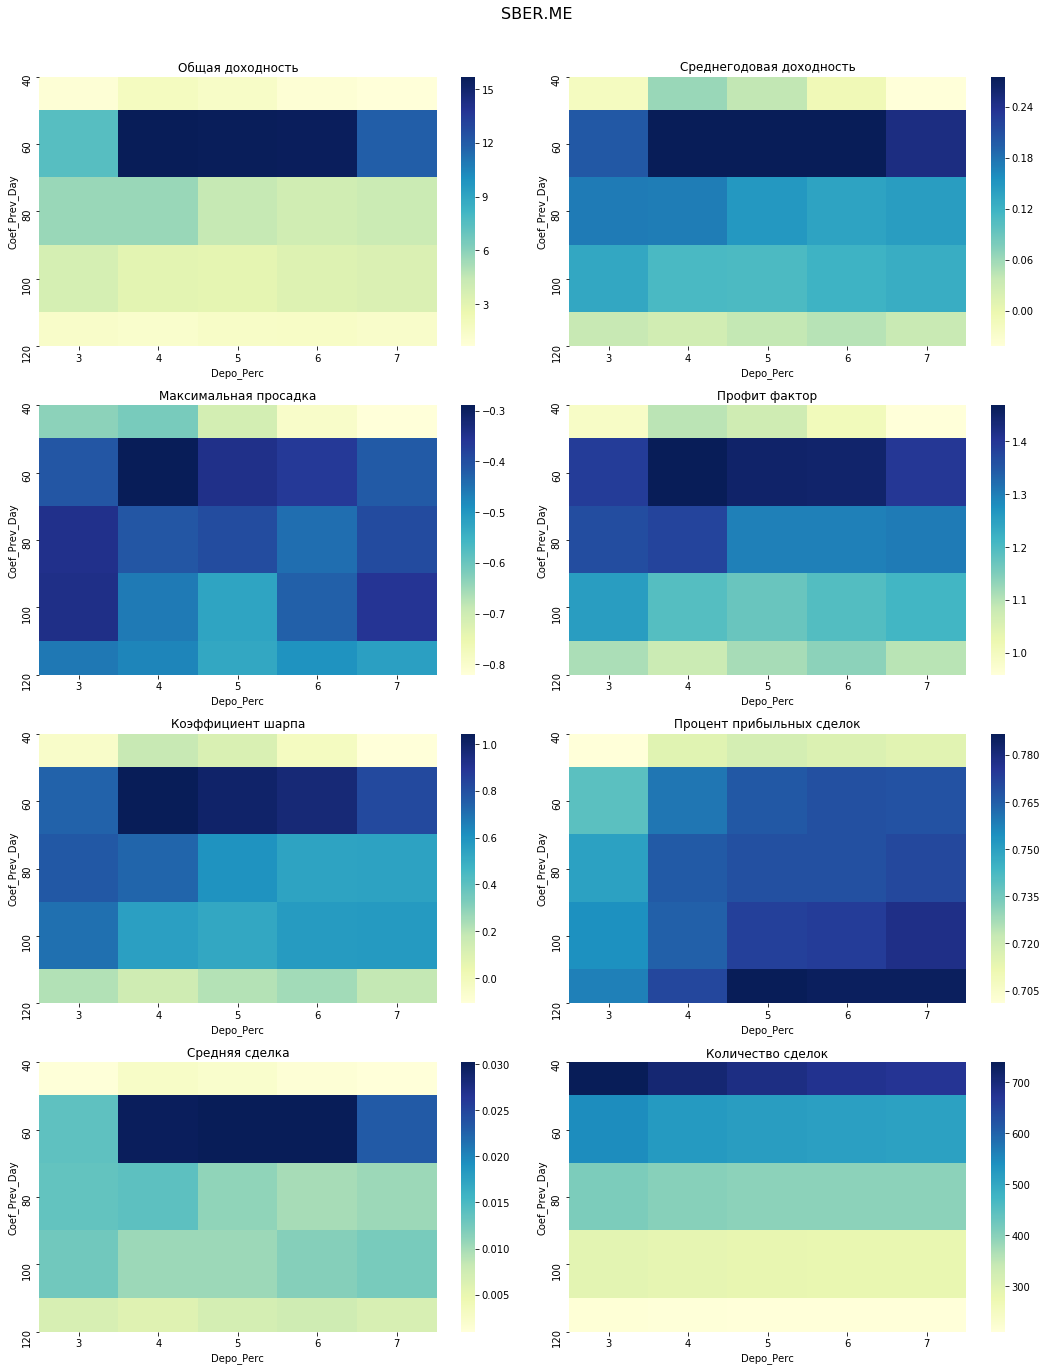

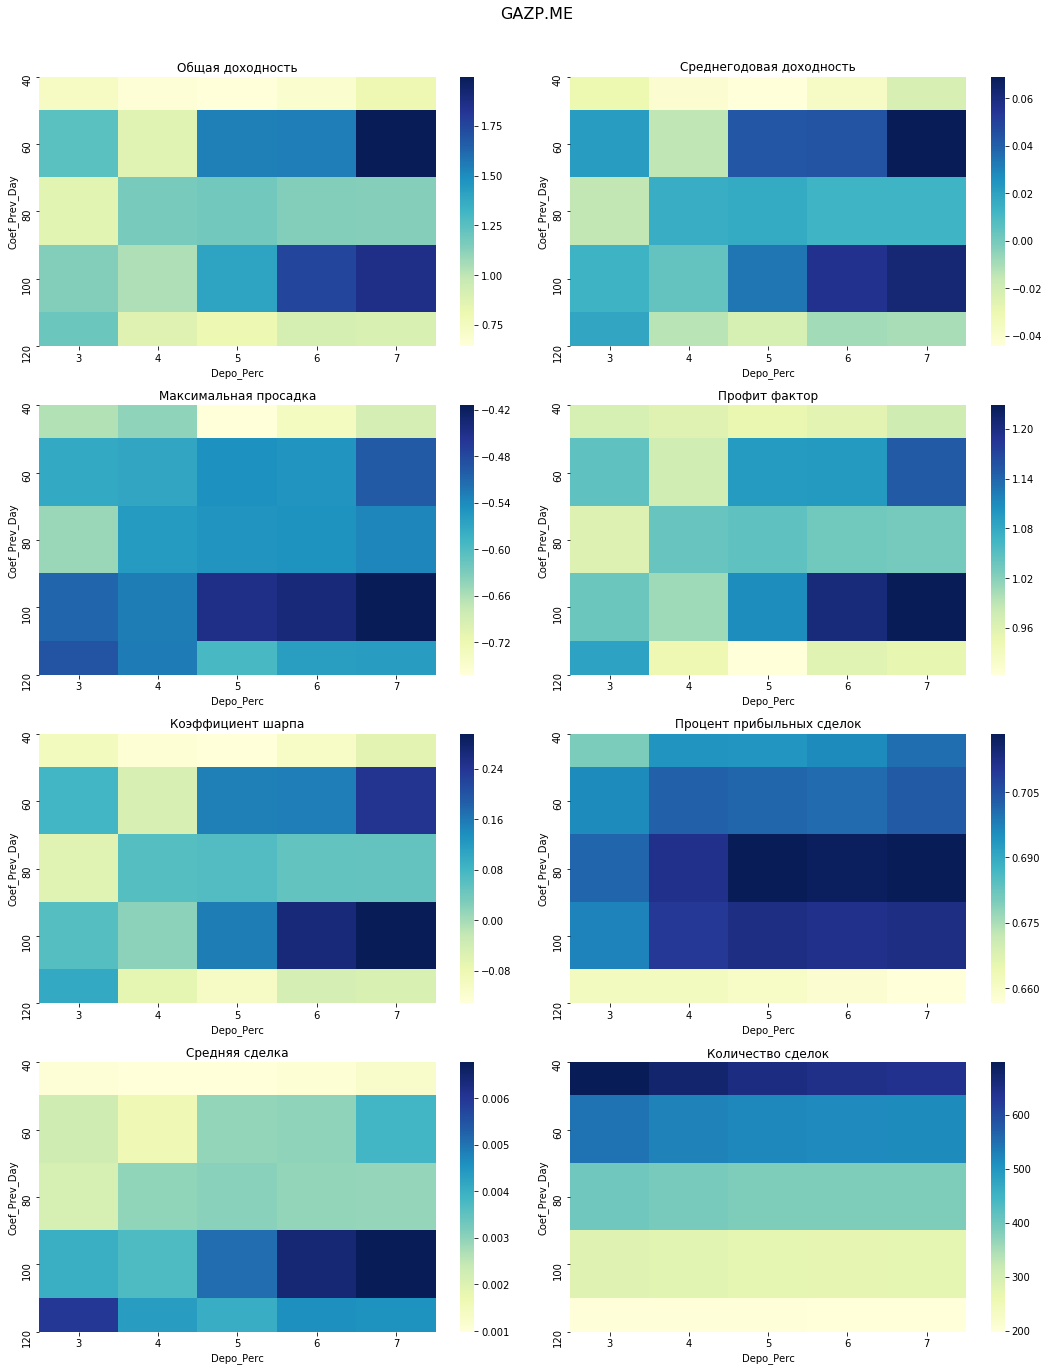

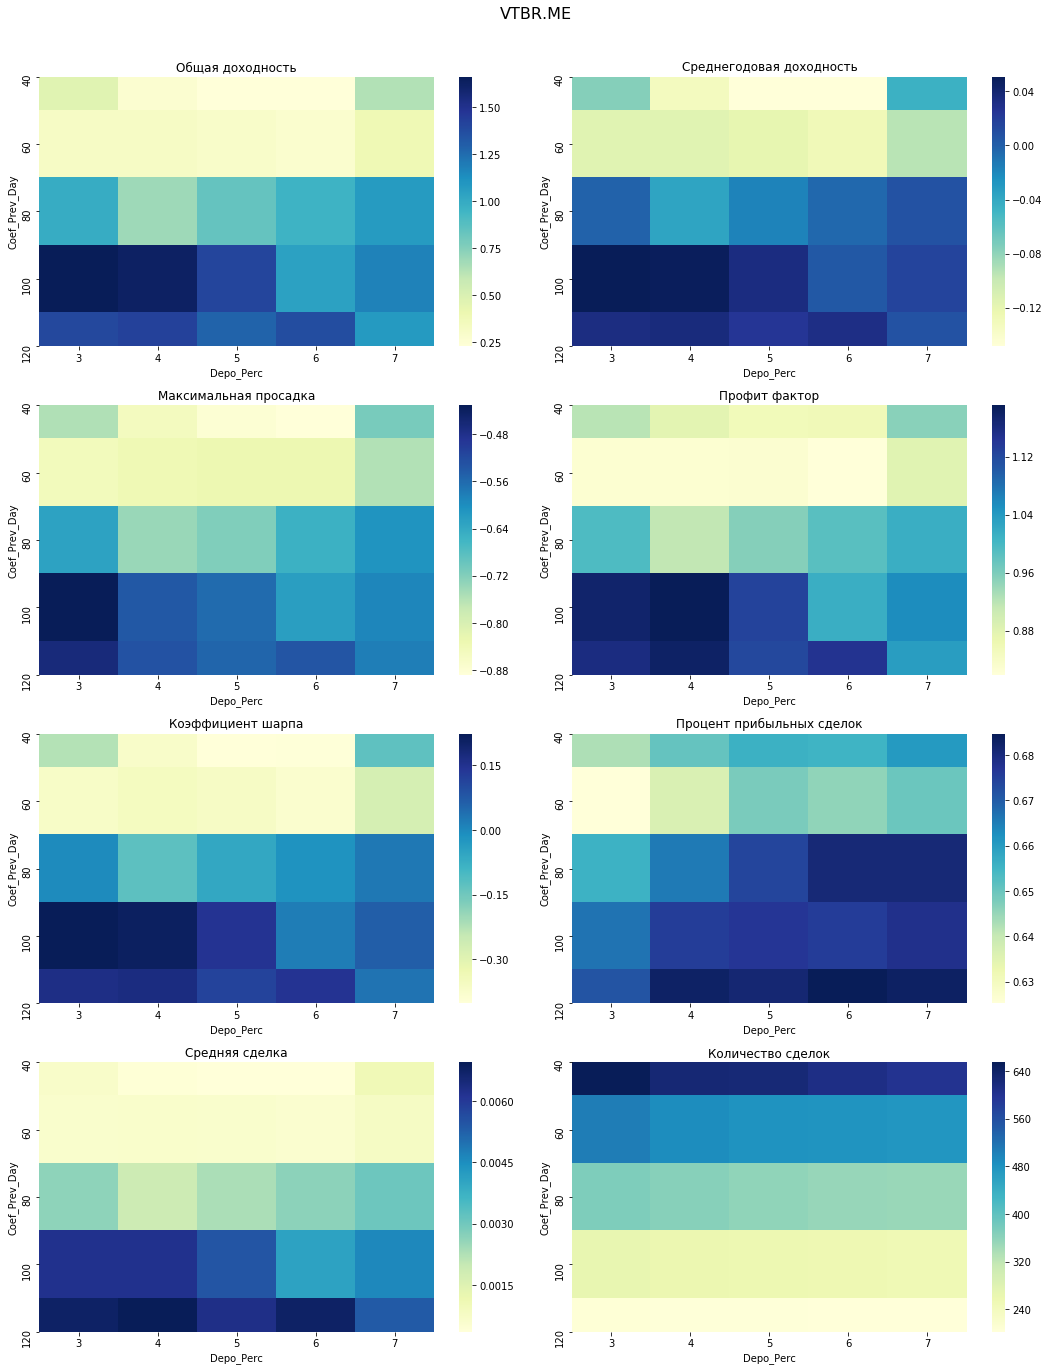

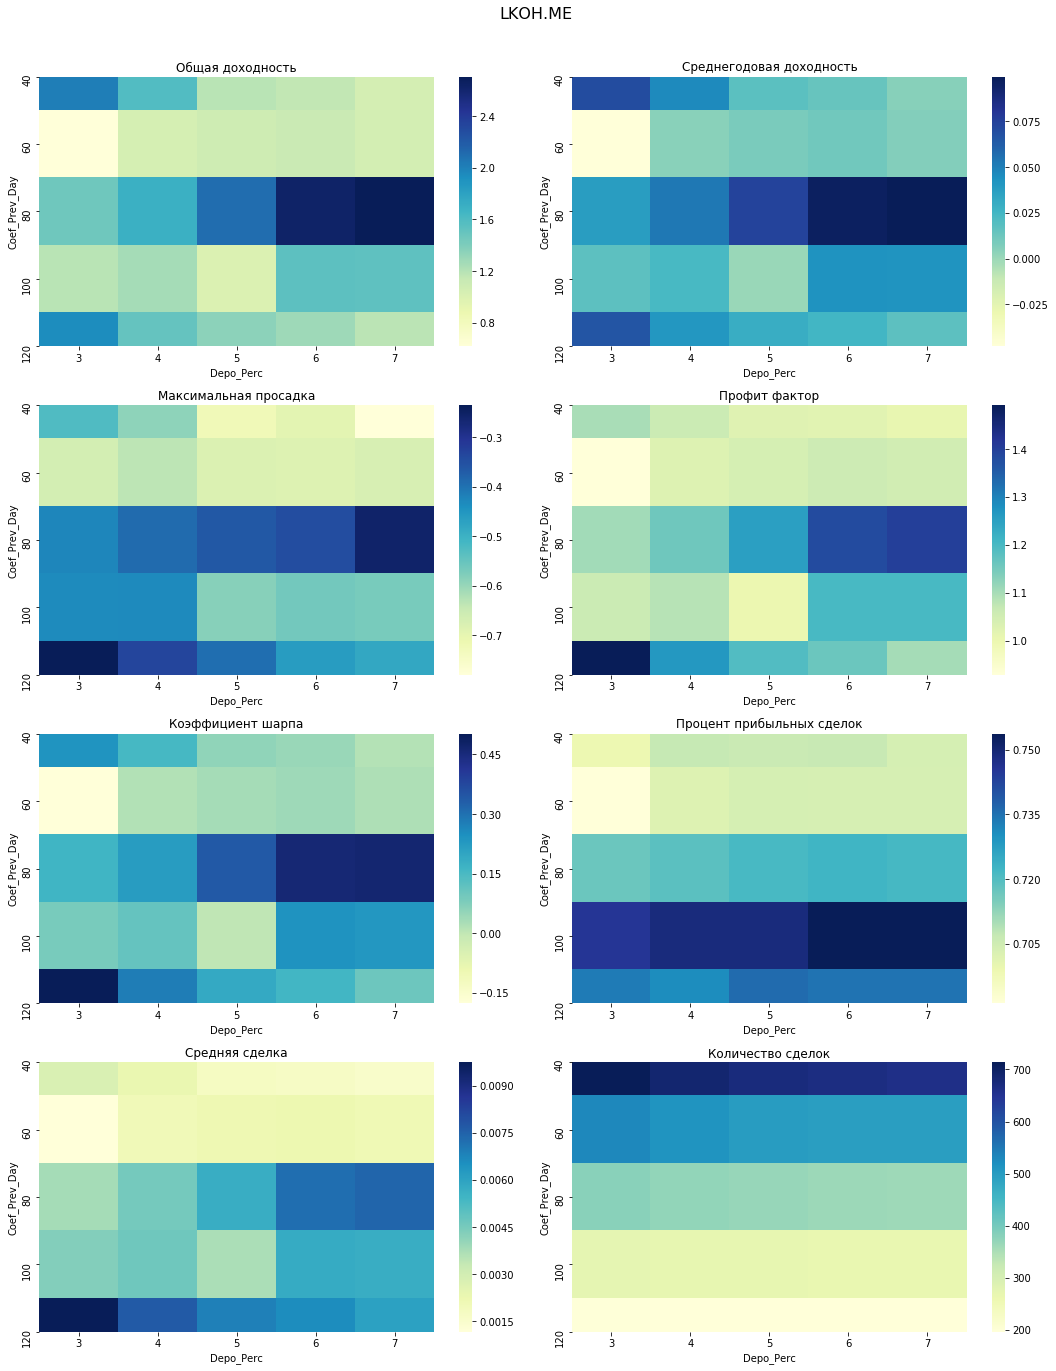

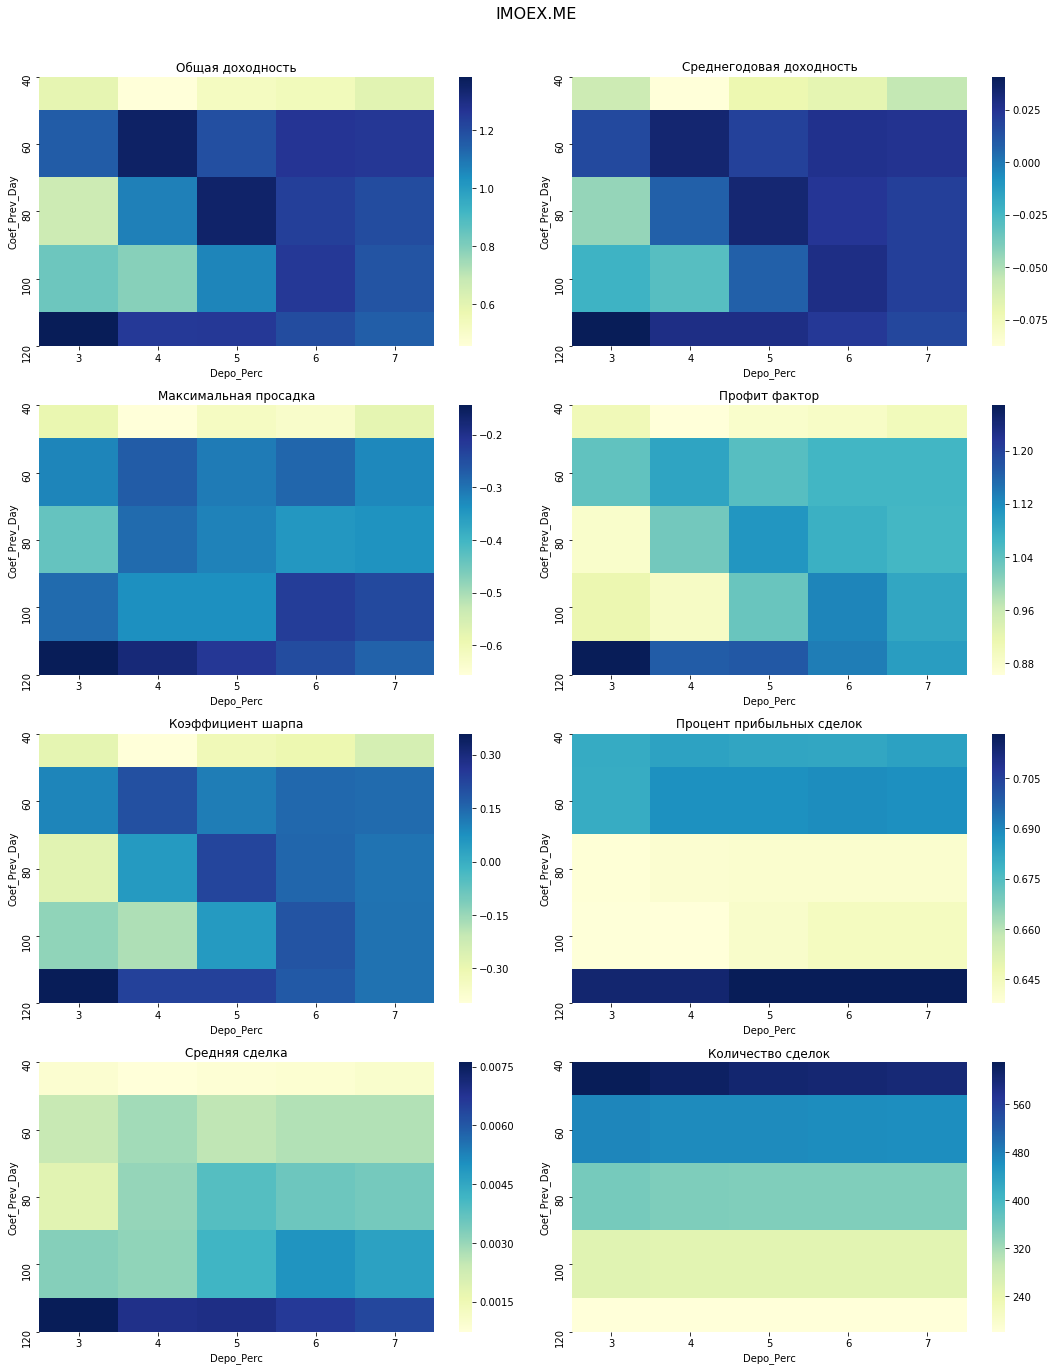

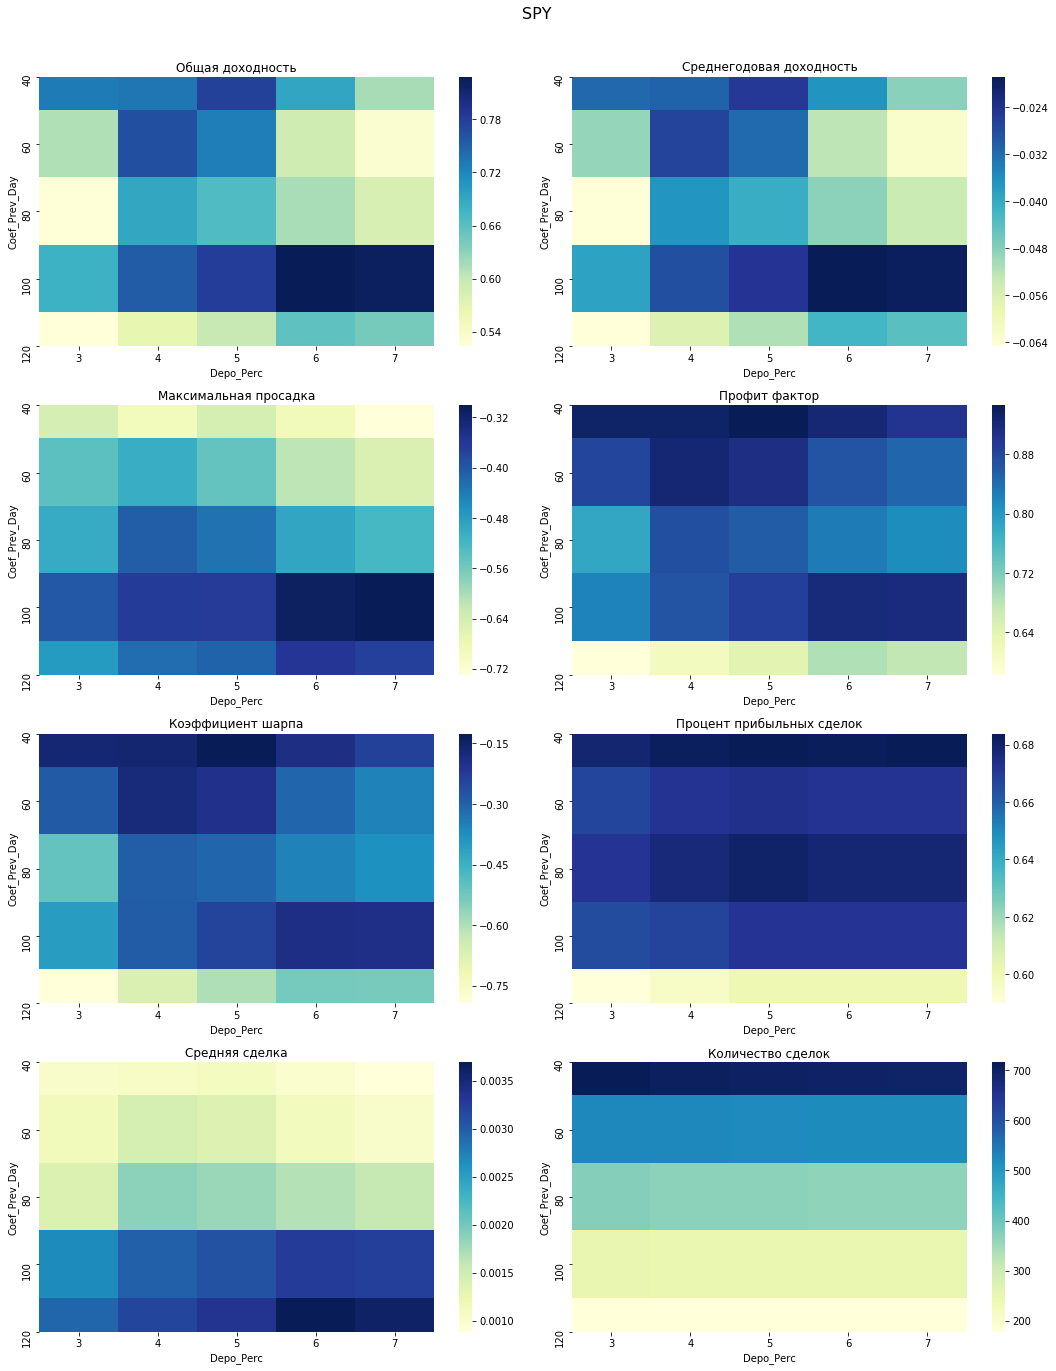

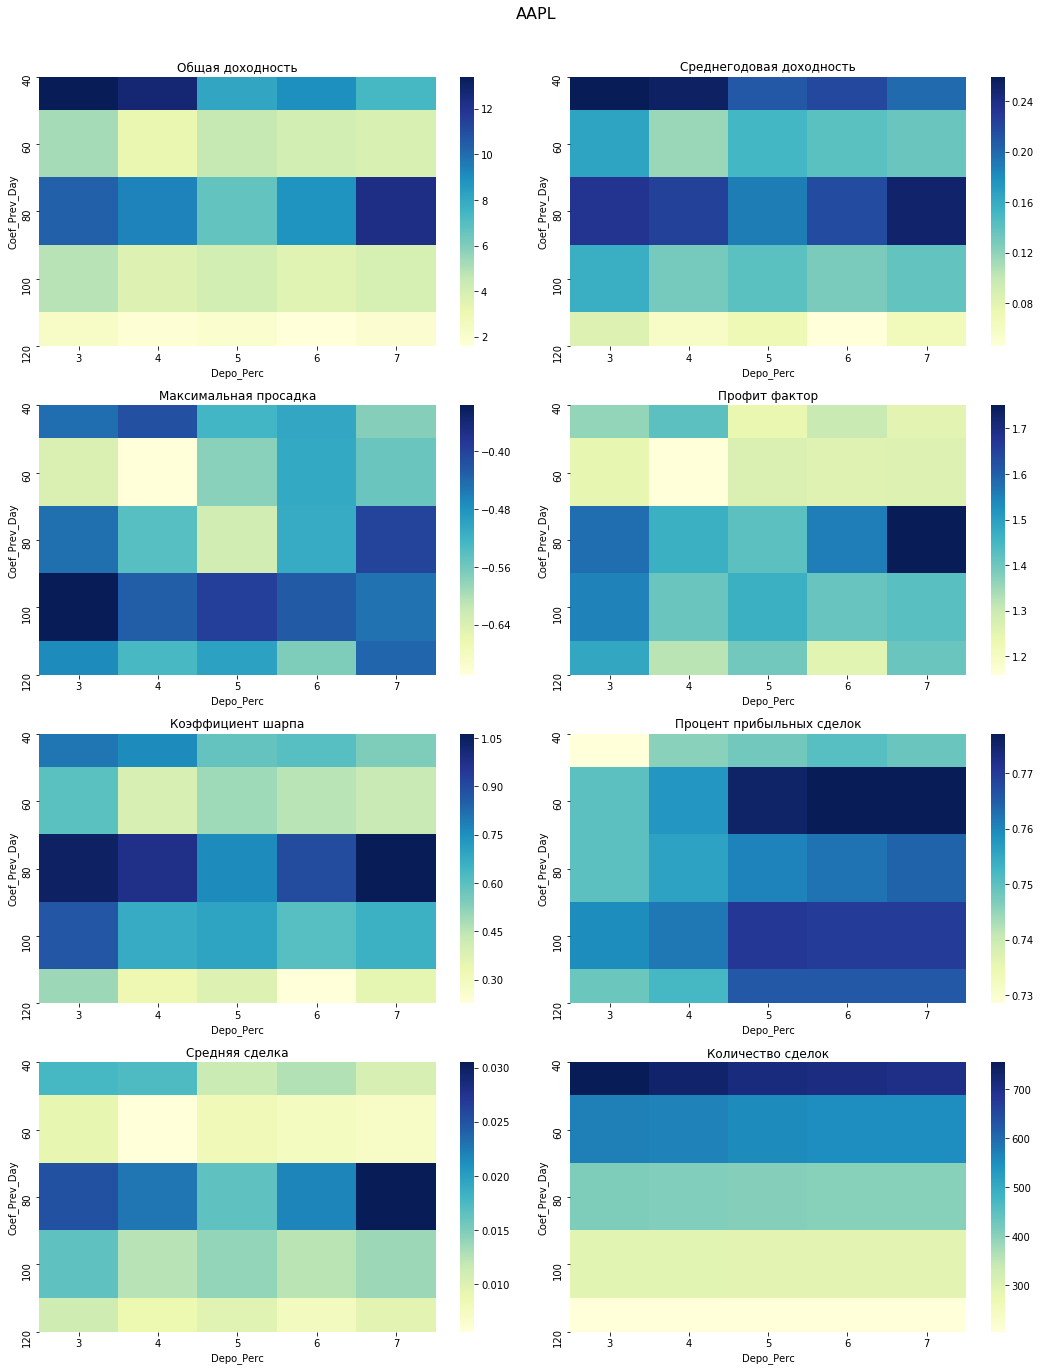

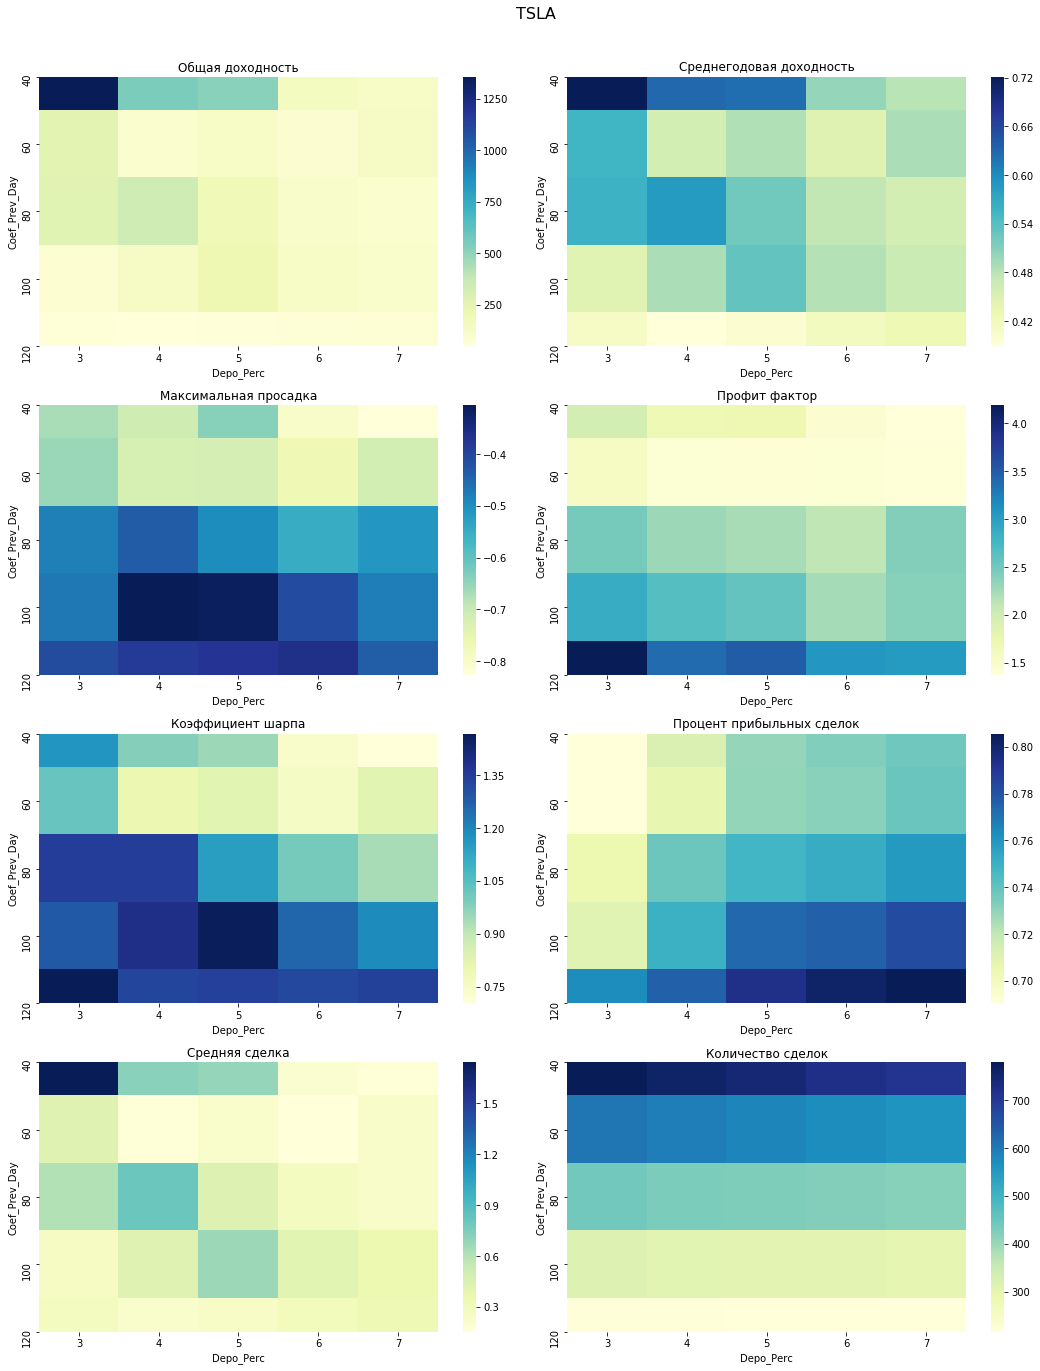

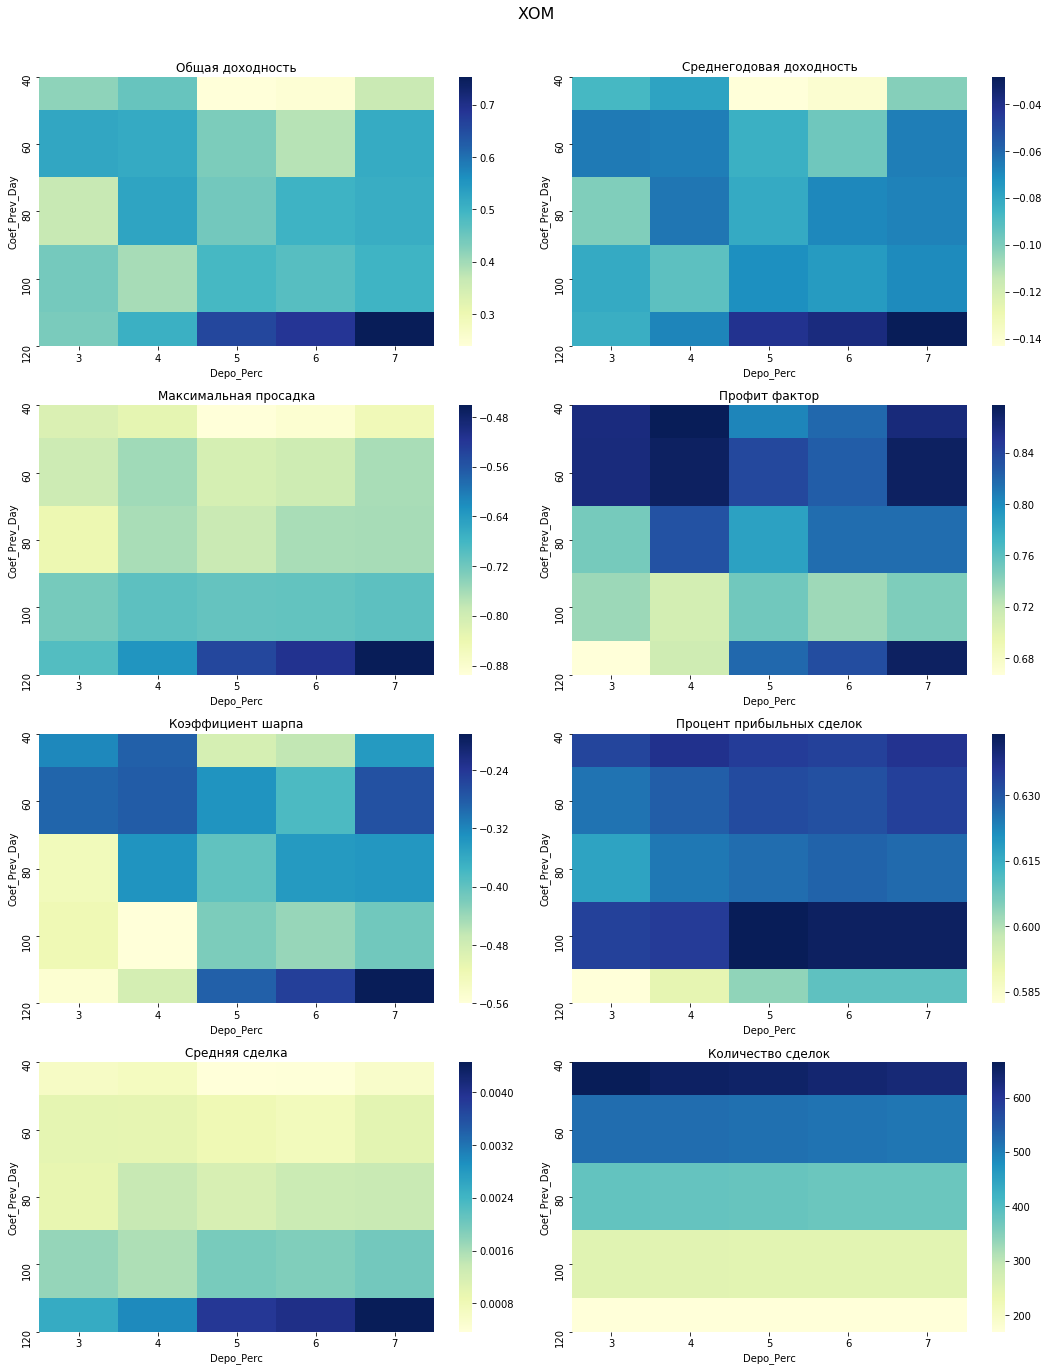

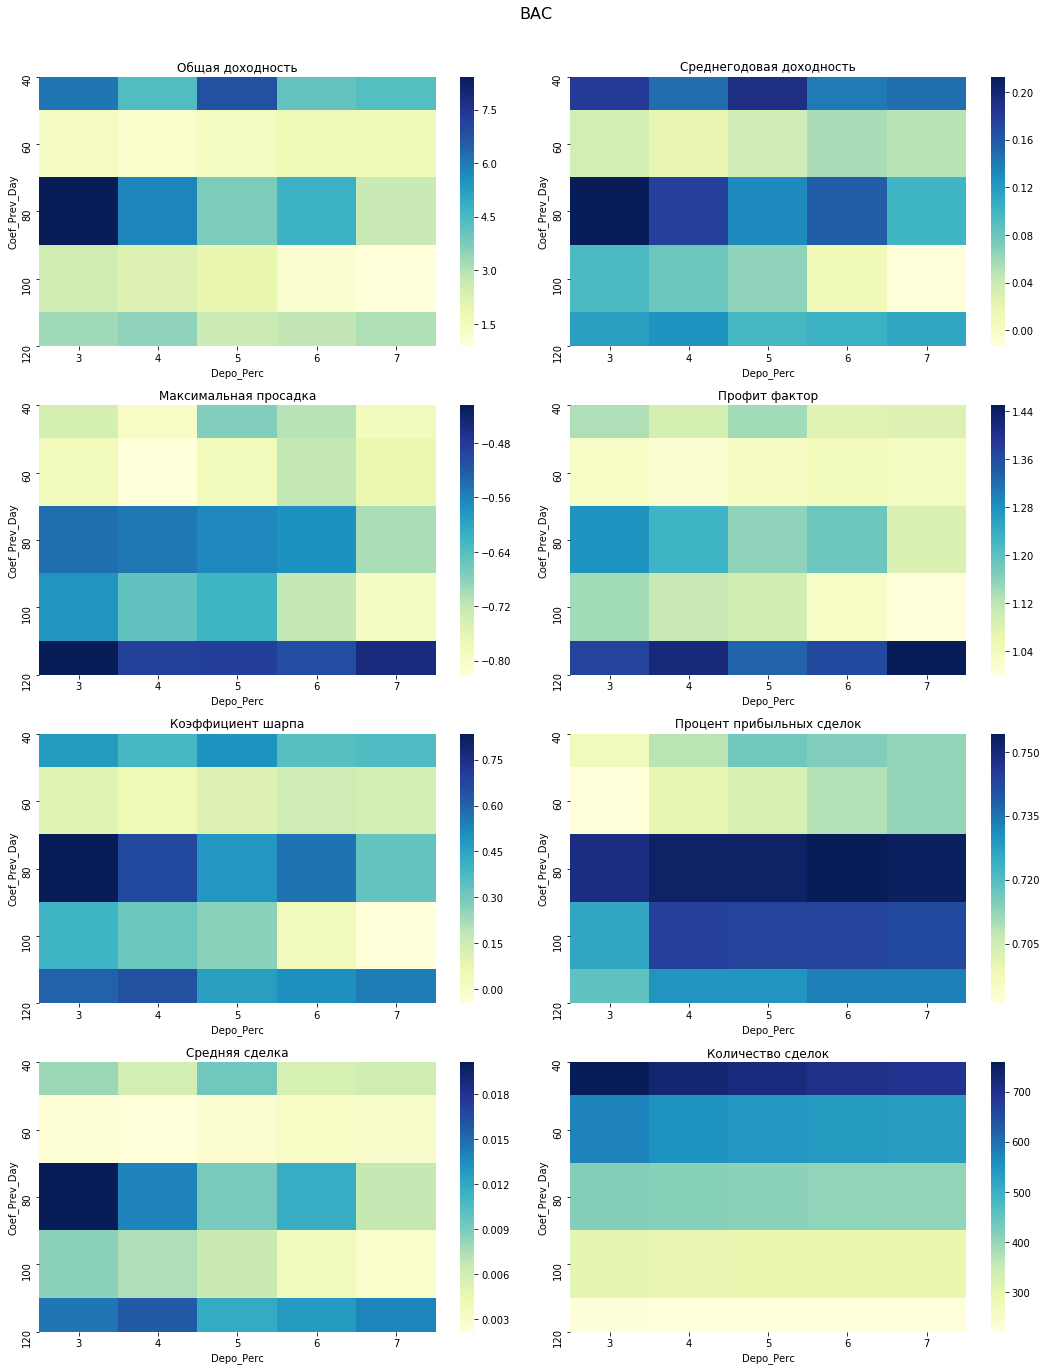

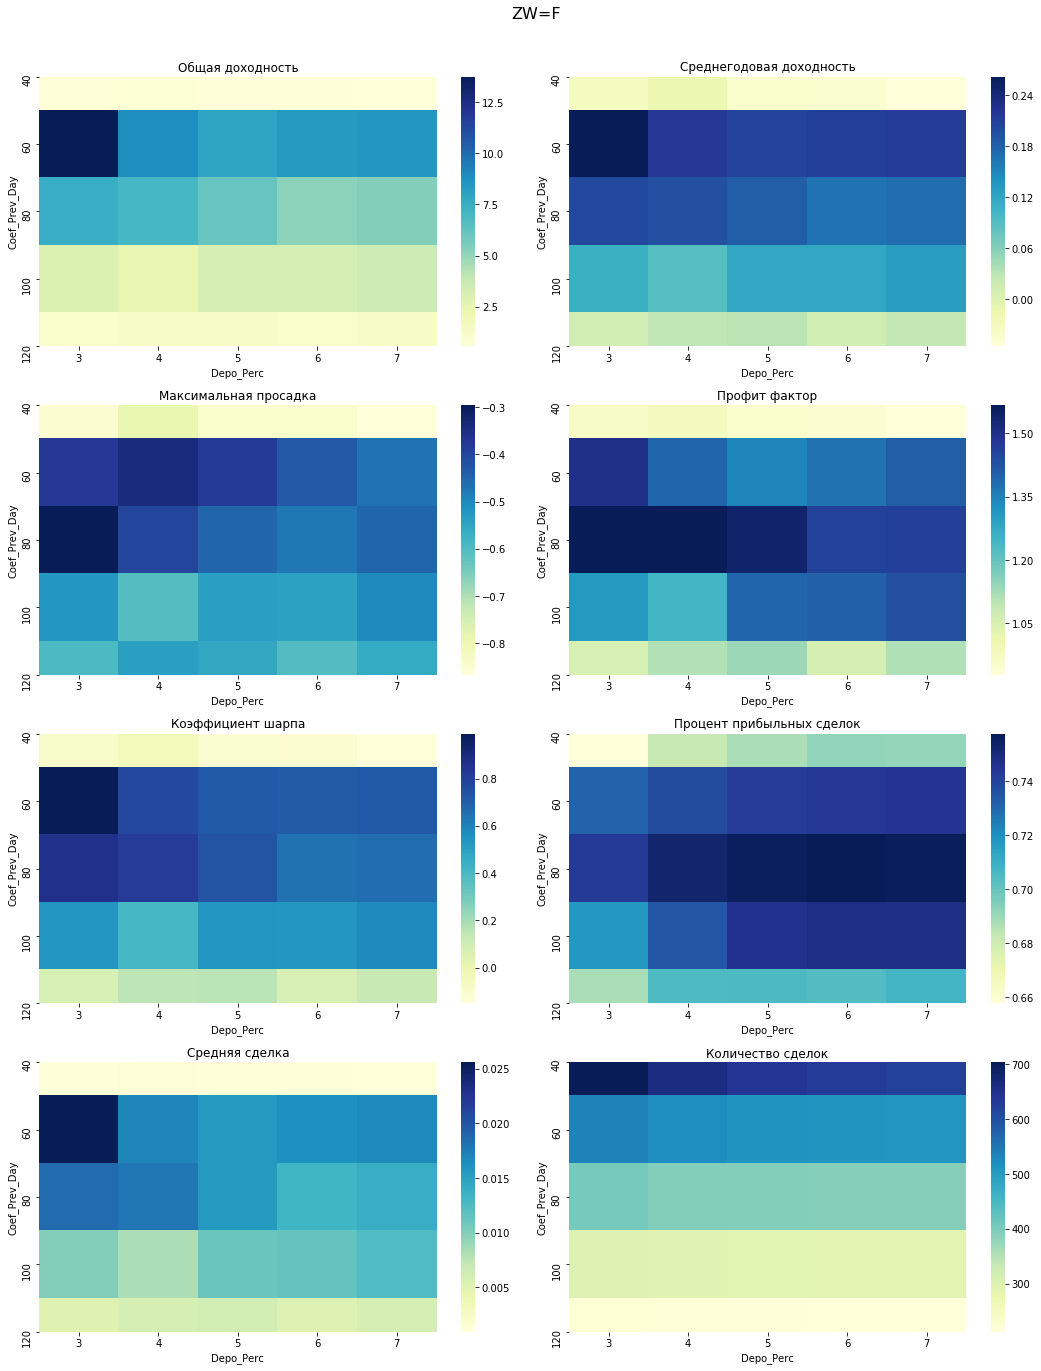

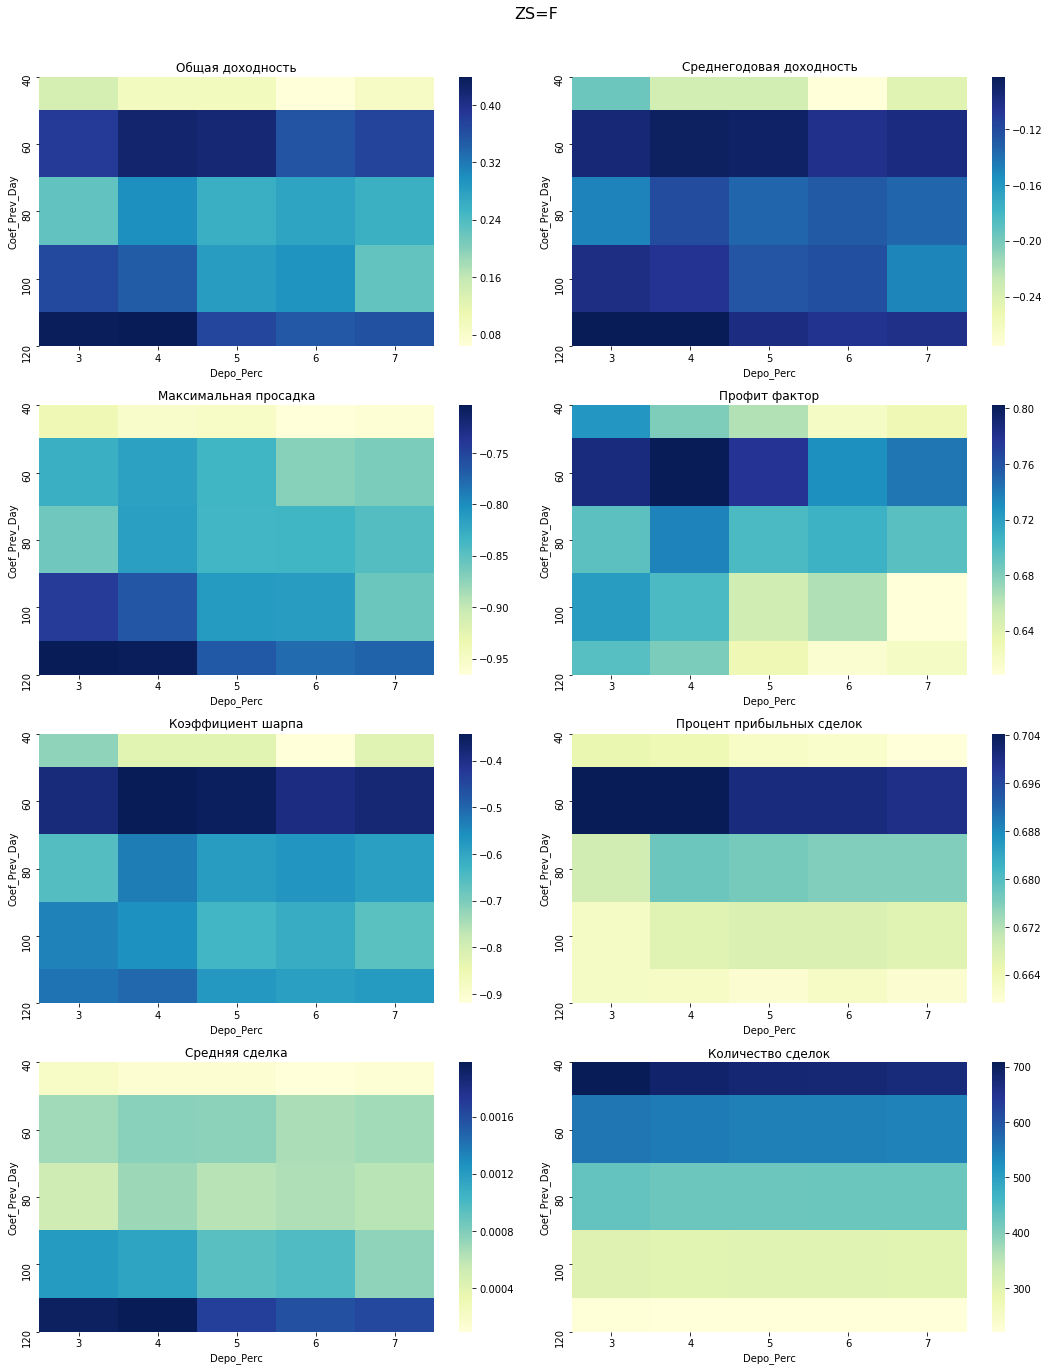

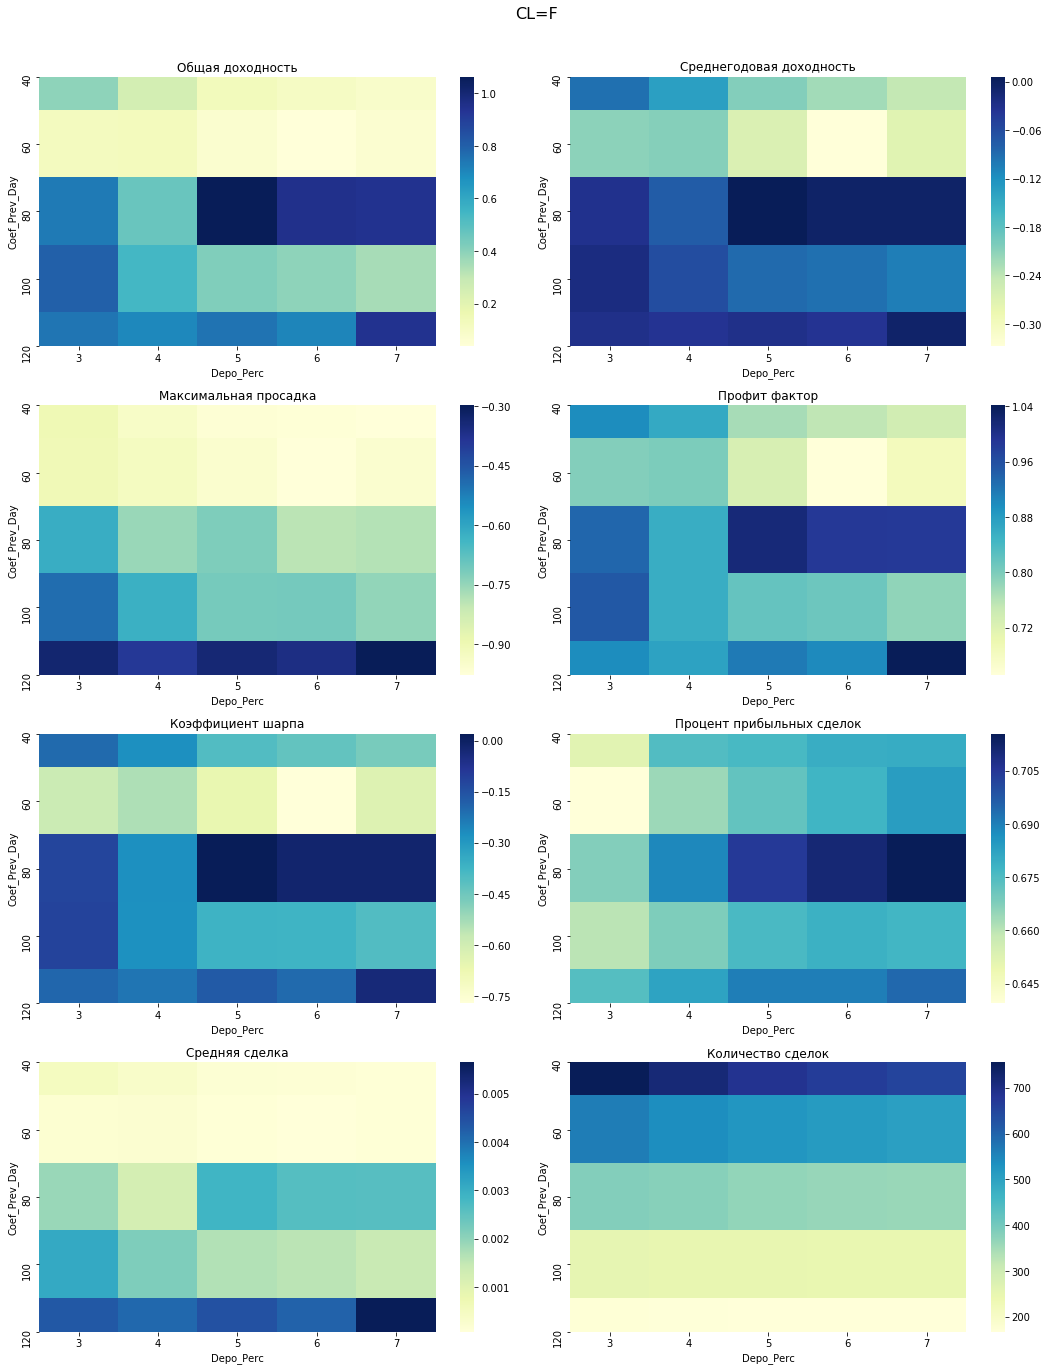

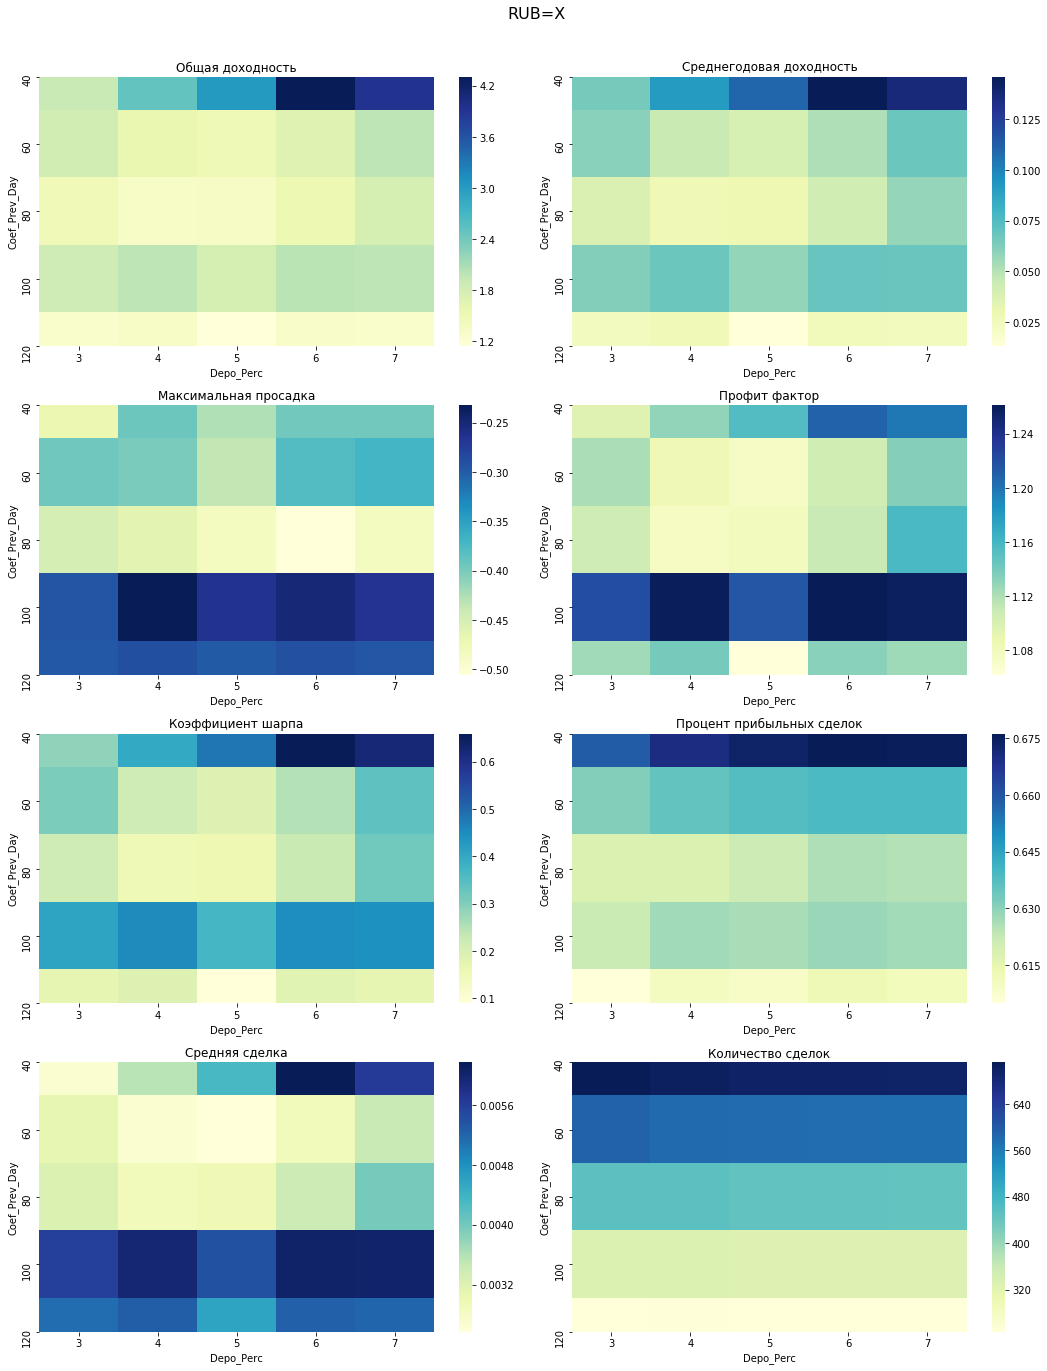

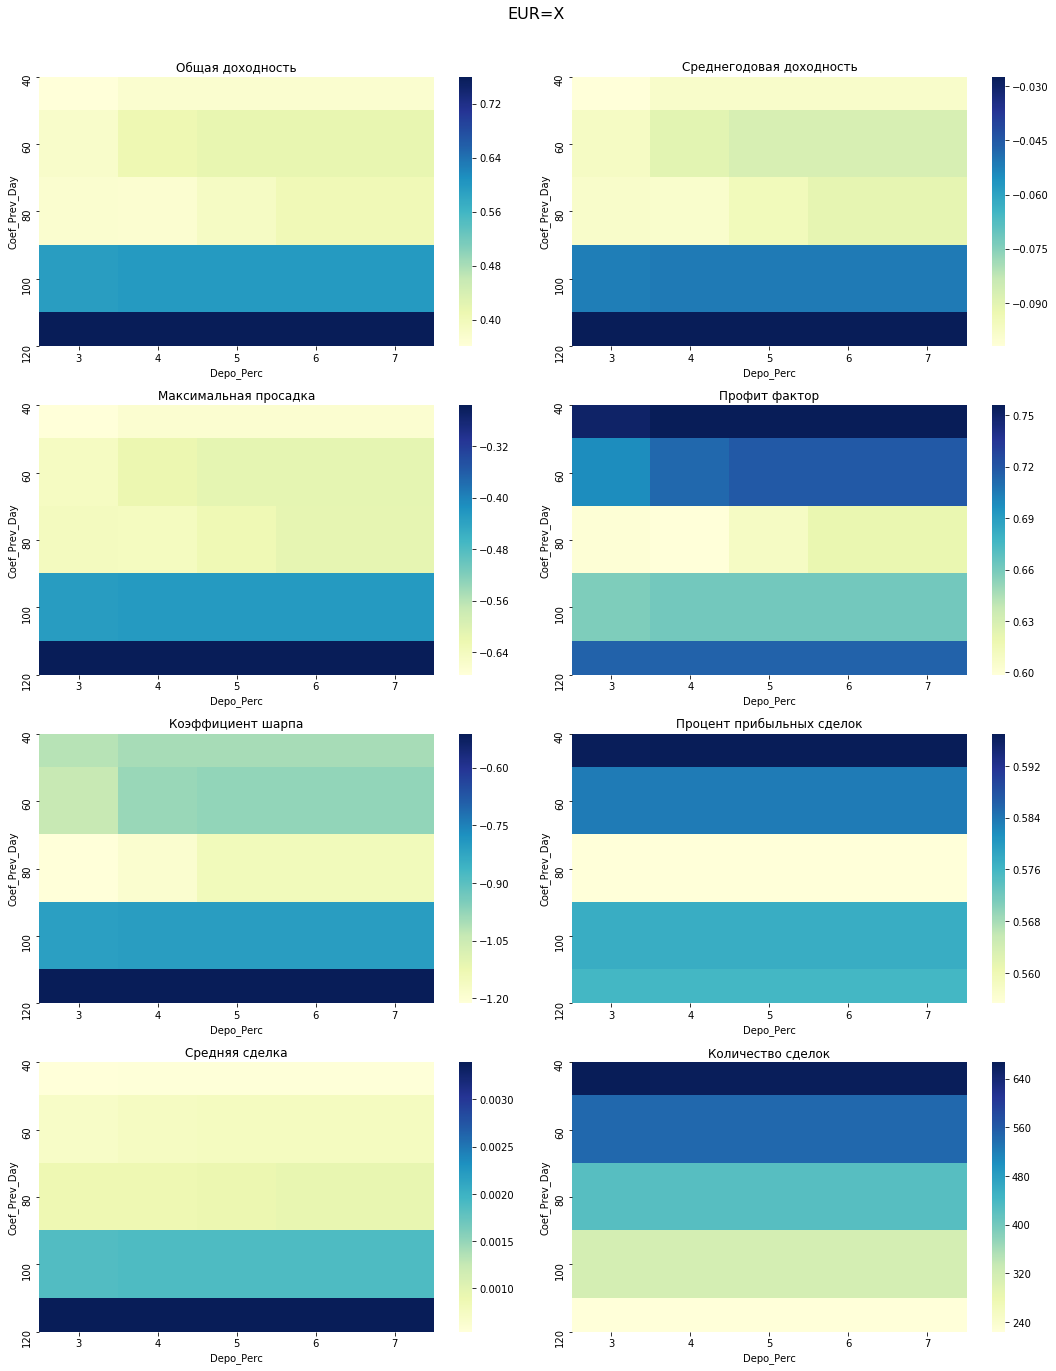

In [19]:
for asset in assets:
    buy = stat[(stat['Direction'] == 'Buy') & (stat['Asset'] == asset)]
    draw_asset_heatmap(buy, asset)

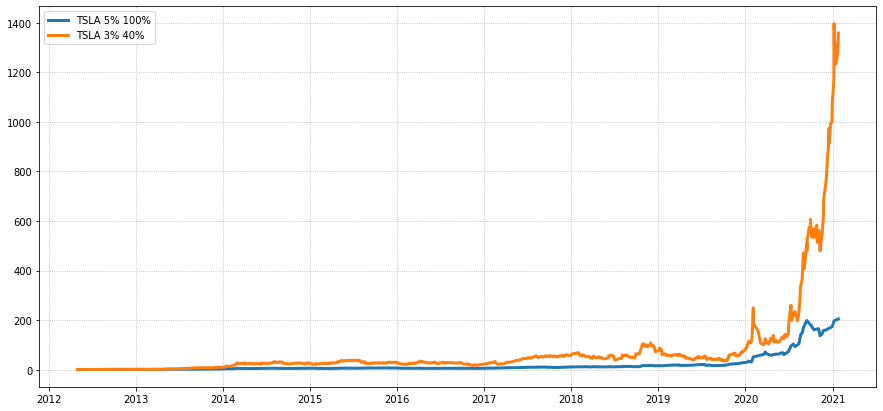

In [68]:
fig, ax = plt.subplots(figsize=(15,7))

line1, = ax.plot(buy_logs_coef['TSLA_100_5']['Return_Buy_Trades_Fees'])
line2, = ax.plot(buy_logs_coef['TSLA_40_3']['Return_Buy_Trades_Fees'])
plt.legend([line1, line2],['TSLA 5% 100%', 'TSLA 3% 40%'])
plt.show()

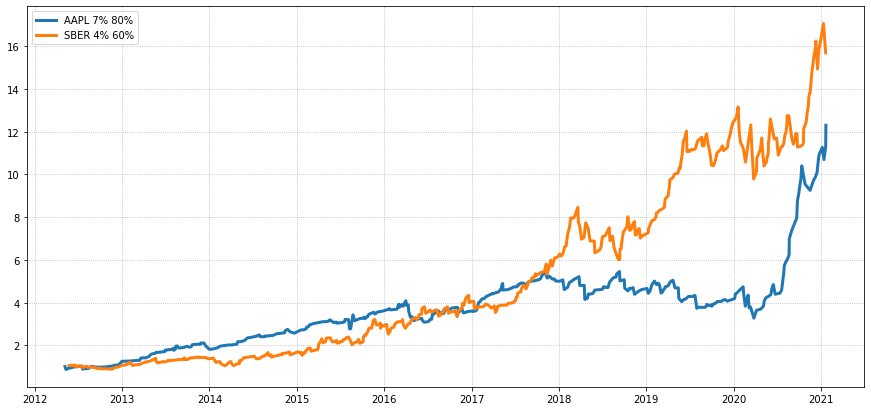

In [70]:
fig, ax = plt.subplots(figsize=(15,7))
line1, = ax.plot(buy_logs_coef['AAPL_80_7']['Return_Buy_Trades_Fees'])
line2, = ax.plot(buy_logs_coef['SBER.ME_60_4']['Return_Buy_Trades_Fees'])
plt.legend([line1, line2],['AAPL 7% 80%', 'SBER 4% 60%'])
plt.show()
#print_stat(stat, 'TSLA_40_3_Buy_Trades_Fees')

In [33]:
ind = [
    'TSLA_100_5_Buy_Trades_Fees',
    'AAPL_80_7_Buy_Trades_Fees',
    'ME_60_4_Buy_Trades_Fees'
]

stat.loc[ind]

Asset Direction Coef_Prev_Day Depo_Perc  \
TSLA_100_5_Buy_Trades_Fees  TSLA       Buy           100         5   
AAPL_80_7_Buy_Trades_Fees   AAPL       Buy            80         7   
ME_60_4_Buy_Trades_Fees      NaN       NaN           NaN       NaN   

                            Start_Date    End_Date  Return_On_Account  \
TSLA_100_5_Buy_Trades_Fees  2012-05-01  2021-01-25         204.381049   
AAPL_80_7_Buy_Trades_Fees   2012-05-07  2021-01-21          12.298831   
ME_60_4_Buy_Trades_Fees            NaN         NaN                NaN   

                            Avg_Year_Return  Num_Of_Trades Num_Of_Win_Trades  \
TSLA_100_5_Buy_Trades_Fees         0.531999          305.0               236   
AAPL_80_7_Buy_Trades_Fees          0.250950          403.0               308   
ME_60_4_Buy_Trades_Fees                 NaN            NaN               NaN   

                            ... Largest_Loss_trade  Avg_Win_Trade  \
TSLA_100_5_Buy_Trades_Fees  ...          -0.213535       0.042996   
AAPL_80_7_Buy_Trades_Fees   ...          -0.147141       0.020601   
ME_60_4_Buy_Trades_Fees     ...                NaN            NaN   

                            Avg_Loss_Trade  Avg_Win_Avg_Loss  Avg_Trade  \
TSLA_100_5_Buy_Trades_Fees       -0.069957          0.614602   0.670102   
AAPL_80_7_Buy_Trades_Fees        -0.040373          0.510252   0.030518   
ME_60_4_Buy_Trades_Fees                NaN               NaN        NaN   

                            Max_Cons_Win  Max_Cons_Loss  Max_Drawdown  \
TSLA_100_5_Buy_Trades_Fees            31              4     -0.312092   
AAPL_80_7_Buy_Trades_Fees             15              3     -0.400541   
ME_60_4_Buy_Trades_Fees              NaN            NaN           NaN   

                           Profit_Factor Sharpe_Ratio  
TSLA_100_5_Buy_Trades_Fees      2.575792     1.460765  
AAPL_80_7_Buy_Trades_Fees       1.750928     1.063589  
ME_60_4_Buy_Trades_Fees              NaN          NaN  

[3 rows x 23 columns]